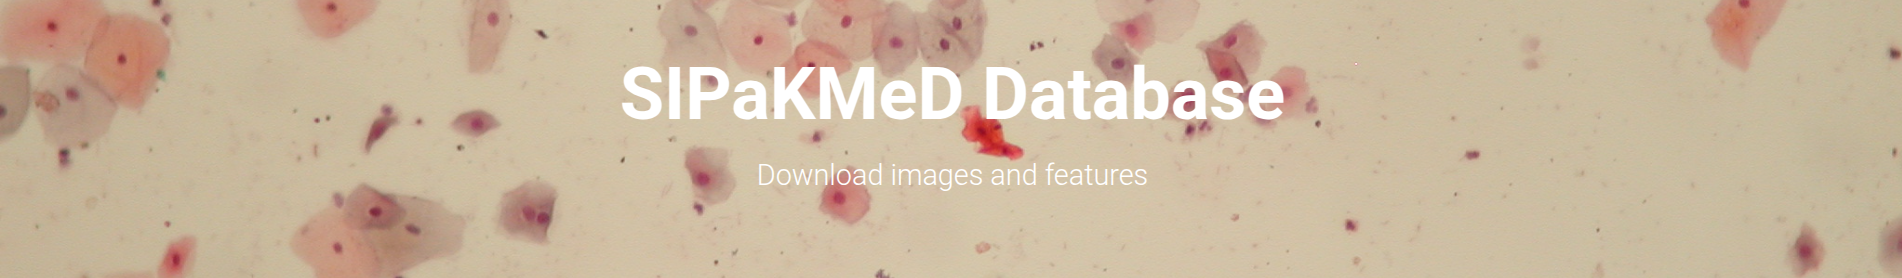

The SIPaKMeD database is publicly available and it can be used for experimental purposes with the request to cite the following paper:

**Marina E. Plissiti, Panagiotis Dimitrakopoulos, Giorgos Sfikas, Christophoros Nikou, Olga Krikoni, Antonia Charchanti, SIPAKMED: A new dataset for feature and image based classification of normal and pathological cervical cells in Pap smear images, IEEE International Conference on Image Processing (ICIP) 2018, Athens, Greece, 7-10 October 2018.**

In [2]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join("../.."))
sys.path.append(PROJECT_ROOT)


In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import cv2
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import torch.optim as optim         
from matplotlib import pyplot as plt

import json, logging
import math

from utils.utils import set_seed, get_device, save_history, load_history
from src.uncertainty_Quantification.train import train_model,train_deep_ensemble, get_dataloader
from src.uncertainty_Quantification.test import evaluate_model, evaluate_deep_ensemble, evaluate_mc_dropout
from src.uncertainty_Quantification.models import SingleNetwork, MCDropoutNetwork, DeepEnsemble
from src.uncertainty_Quantification.losses import edl_mse_loss, edl_digamma_loss, edl_log_loss, relu_evidence 
# from src.uncertainty_Quantification.metrics import 

set_seed(42)

DEVICE = get_device()

In [6]:
set_seed(42)
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
PATIENCE =10
ENSEMBLE_SIZE = 10
NUM_SAMPLES = 10

train_loader = get_dataloader("train", BATCH_SIZE, typeofdata="sipakmed_features")
val_loader = get_dataloader("val", BATCH_SIZE, typeofdata="sipakmed_features")

input_dim = train_loader.dataset.tensors[0].shape[1]
num_classes = len(set(train_loader.dataset.tensors[1].numpy()))
print(f"Input Dimension: {input_dim}, Num Classes: {num_classes}")

Input Dimension: 2048, Num Classes: 5


**Performance**

In [8]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from netcal.binning import HistogramBinning
from netcal.scaling import TemperatureScaling, BetaCalibration
from netcal.metrics import ECE
from netcal.presentation import ReliabilityDiagram

# Import project files
import sys
PROJECT_PATH = os.path.abspath(os.path.join("../.."))  # 🔹 Better path handling
sys.path.append(PROJECT_PATH)
from src.uncertainty_Quantification.models import SingleNetwork, MCDropoutNetwork
from utils.utils import enable_dropout, get_device



PROJECT_PATH = os.path.abspath(os.path.join( "../.."))
MODEL_SAVE_PATH = os.path.join(PROJECT_PATH, "outputs/models")
RESULTS_PATH = os.path.join(PROJECT_PATH, "outputs/calibration/")
DEVICE = get_device()

/tmp/ipykernel_1293574/4085156898.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "SingleNetwork.pth"), m

Single Network ECE Scores: {'histogram': 0.020005398709785734}


/tmp/ipykernel_1293574/4085156898.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Deep Ensemble ECE Scores: {'histogram': 0.014959573158489621}


/tmp/ipykernel_1293574/4085156898.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "MCDropout.pth"), map_l

MC Dropout ECE Scores: {'histogram': 0.010241193430764309}


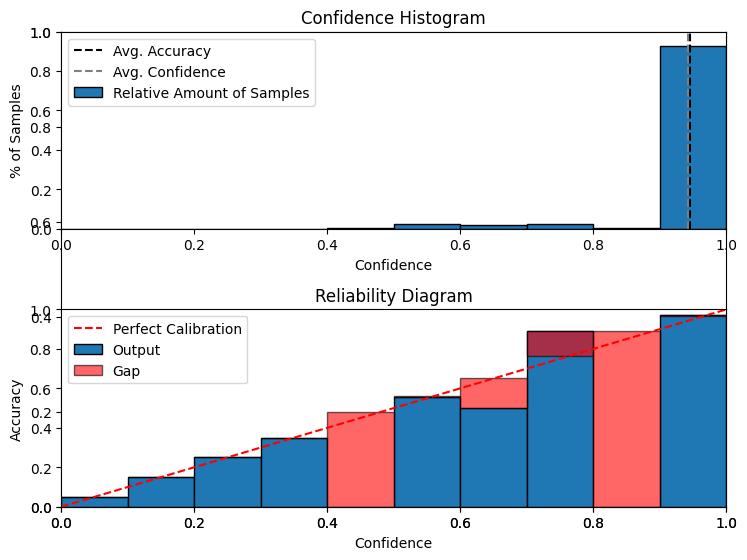

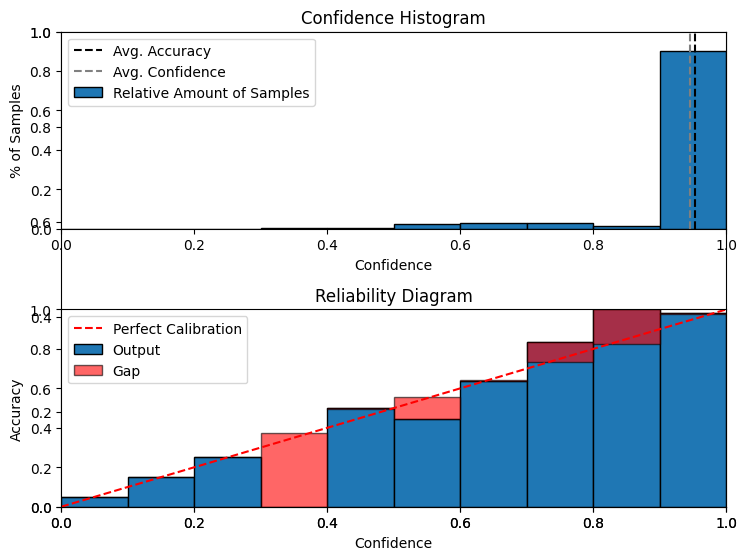

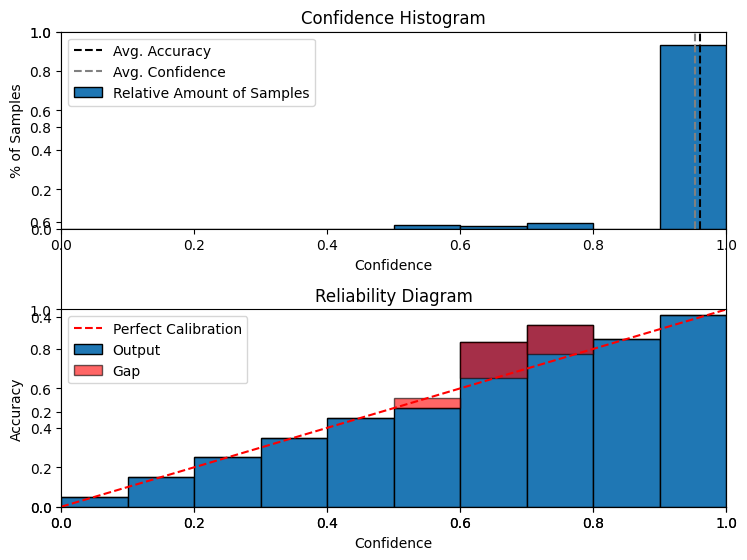

In [7]:
def evaluate_with_calibration(model_type, dataloader, device, method="histogram", bins=10, args=None):
    """
    Evaluate model calibration using different methods and display results in a row with 3 columns.

    Args:
        model_type (str): Model type ("single", "deep_ensemble", "mc_dropout").
        dataloader (torch.utils.data.DataLoader): DataLoader for test dataset.
        device (torch.device): Device to run the model on.
        methods (list): List of calibration methods to use.
        bins (int): Number of bins for binning-based calibration.
        args (dict or None): Additional parameters for deep ensemble and MC Dropout.

    Returns:
        None
    """
    all_preds, all_labels = [], []
    
    # 🔹 Load Single Model
    if model_type == "single":
        model = SingleNetwork().to(device)
        model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "SingleNetwork.pth"), map_location=device))
        model.eval()

        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            with torch.no_grad():
                preds = torch.softmax(model(X_batch), dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    # 🔹 Load Deep Ensemble
    elif model_type == "deep_ensemble":
        models = []
        ensemble_size = args.get("ensemble_size", 5) if args else 5  # Default ensemble size

        for i in range(ensemble_size):
            model = SingleNetwork().to(device)
            model_path = os.path.join(MODEL_SAVE_PATH, f"DeepEnsemble_{i}.pth")
            if not os.path.exists(model_path):
                print(f"Missing Deep Ensemble model: {model_path}")
                continue
            model.load_state_dict(torch.load(model_path, map_location=device))
            model.eval()
            models.append(model)

        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            with torch.no_grad():
                preds = torch.stack([torch.softmax(model(X_batch), dim=1) for model in models])
                mean_preds = preds.mean(dim=0)
            all_preds.append(mean_preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    # 🔹 Load MC Dropout
    elif model_type == "mc_dropout":
        model = MCDropoutNetwork().to(device)
        model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "MCDropout.pth"), map_location=device))
        model.eval()
        enable_dropout(model)  # Keep dropout active for uncertainty estimation

        num_samples = args.get("num_samples", 50) if args else 50  # Default num_samples

        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            with torch.no_grad():
                preds = torch.stack([torch.softmax(model(X_batch), dim=1) for _ in range(num_samples)])
                mean_preds = preds.mean(dim=0)
            all_preds.append(mean_preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    else:
        raise ValueError(f"Invalid model type: {model_type}")

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # 🔹 Compare Calibration Methods
    ece_scores = {}
    figs = []
    methods = {
        "histogram": HistogramBinning(bins=bins),
        # "temperature_scaling": TemperatureScaling(),
        # "beta_calibration": BetaCalibration()    
    }
    
    
    for method_name, method in methods.items():
        method.fit(all_preds, all_labels)
        calibrated_preds = method.transform(all_preds)
        ece = ECE(bins=bins)
        ece_val = ece.measure(calibrated_preds, all_labels)
        ece_scores[method_name] = ece_val

        # 🔹 Generate Reliability Diagram
        fig = plt.figure(figsize=(8, 6))
        reliability_diagram = ReliabilityDiagram()
        reliability_diagram.plot(calibrated_preds, all_labels, ax=plt.gca(), fig=fig)
        figs.append(fig)
    
    return ece_scores, figs
    

ece_scores_single_net, _ = evaluate_with_calibration("single", test_loader, DEVICE)
print(f"Single Network ECE Scores: {ece_scores_single_net}")

ece_scores_deep_ensemble, _ = evaluate_with_calibration("deep_ensemble", test_loader, DEVICE, args={"ensemble_size": ENSEMBLE_SIZE})
print(f"Deep Ensemble ECE Scores: {ece_scores_deep_ensemble}")

ece_scores_mc_dropout, _ = evaluate_with_calibration("mc_dropout", test_loader, DEVICE, args={"num_samples": 15})
print(f"MC Dropout ECE Scores: {ece_scores_mc_dropout}")

In [ ]:


import os, sys
PATH = os.path.abspath(os.path.join( "../../"))
sys.path.append(PATH)
from utils.utils import get_dataloaders
from src.uncertainty_Quantification.train import train_model, train_deep_ensemble
from src.uncertainty_Quantification.test import evaluate_model, monte_carlo_dropout, evaluate_mc_dropout
from src.uncertainty_Quantification.models import FineTunedResNet50

dropout_rate = 0.4
learning_rate = 0.0001
num_epochs = 50
num_samples, ensemble_size = 10, 10
train_loader, val_loader, cal_loader, test_loader = get_dataloaders( batch_size=32, num_workers=4, model_type="resnet")

model = FineTunedResNet50(num_classes=5, mc_dropout=False, dropout_rate=dropout_rate)
# model_path = PATH + "/outputs/models/SingleNetwork_finetuned_resnet50.pth"
# model.load_state_dict(torch.load(model_path))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=num_epochs, model_name="SingleNetwork_finetuned_resnet50")
res_single_resnet50 = evaluate_model(model, test_loader, model)
print(f"Single Network ResNet50 Test Performance: {res_single_resnet50}")


APS, RAPS, SAPS

In [9]:
import torch
import os
import json
import pandas as pd
from tqdm import tqdm
from torchcp.classification.score import APS, RAPS, SAPS, KNN, TOPK
from torchcp.classification.predictor import SplitPredictor
from utils.utils import set_seed, enable_dropout
from torchcp.classification.utils.metrics import coverage_rate, average_size, CovGap, VioClasses, SSCV
from src.uncertainty_Quantification.models import SingleNetwork, MCDropoutNetwork, DeepEnsemble
import matplotlib.pyplot as plt


set_seed(42)
def plot_set_size_distributions(set_size_distributions, num_classes, save_results_dir):
    """
    Plots the set size distributions for each method and score type.
    Each row corresponds to a different approach (single, ensemble, mc_dropout),
    and each column corresponds to a different model type.
    """
    fig, axes = plt.subplots(nrows=len(set_size_distributions)//3, ncols=3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, (key, sizes) in enumerate(set_size_distributions.items()):
        ax = axes[idx]
        if isinstance(sizes, torch.Tensor):
            sizes = sizes.cpu().numpy().tolist()
        
        ax.hist(sizes, bins=range(1, num_classes + 2), align='left', alpha=0.7, edgecolor='black')
        ax.set_xlabel("Set Size")
        ax.set_ylabel("Frequency")
        ax.set_title(f"{key}")
        ax.set_xticks(range(1, num_classes + 1))
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plot_path = os.path.join(save_results_dir, "set_size_distributions.png")
    plt.savefig(plot_path)
    plt.show()
    plt.close()
    print(f"[INFO] Saved combined plot: {plot_path}")



def mc_dropout_forward(model, x, num_samples=10):
    """
    Runs Monte Carlo Dropout forward pass and returns
    the softmax output for each sample.
    """
    enable_dropout(model)
    with torch.no_grad():
        outputs = torch.stack([torch.softmax(model(x), dim=1) for _ in range(num_samples)])
    return outputs

def dee_ensemble_forward(models, x):
    """_summary_

    Args:
        models (_type_): _description_
        x (_type_): _description_
    """
    with torch.no_grad():
        outputs = torch.stack([torch.softmax(model(x), dim=1) for model in models])
    return outputs
    

def gather_logits_labels(model=None, models=None, loader=None, device="cpu", mc_dropout=False, mc_samples=10):
    """
    Gathers model logits and true labels for calibration.

    Args:
        model (nn.Module, optional): Base classification model (if using a single model).
        models (list of nn.Module, optional): List of models for Deep Ensemble (if using multiple models).
        loader (torch.utils.data.DataLoader): DataLoader for calibration/test set.
        device (torch.device): Device to run the model on.
        mc_dropout (bool): Whether to use MC Dropout.
        mc_samples (int): Number of MC samples.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Logits and true labels.
    """
    if model:
        model.to(device).eval()
    elif models:
        for m in models:
            m.to(device).eval()
    else:
        raise ValueError("Either `model` or `models` must be provided.")

    all_logits, all_labels = [], []

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        if mc_dropout:  
            preds = torch.stack([torch.softmax(model(X_batch), dim=1) for _ in range(mc_samples)])
            logits = preds.mean(dim=0)

        elif models: 
            preds = torch.stack([torch.softmax(m(X_batch), dim=1) for m in models])
            logits = preds.mean(dim=0)

        else: 
            logits = torch.softmax(model(X_batch), dim=1)

        all_logits.append(logits.cpu()) 
        all_labels.append(y_batch.cpu()) 

    all_logits = torch.cat(all_logits, dim=0)  
    all_labels = torch.cat(all_labels, dim=0)

    return all_logits.to(device), all_labels.to(device) 



In [8]:
import torch
import pandas as pd
from torchcp.classification.utils.metrics import coverage_rate, average_size, SSCV
from torchcp.classification.score import APS, RAPS, SAPS
from torchcp.classification.predictor import SplitPredictor


def posthoc_conformal_calibration(
    model=None, models=None, cal_loader=None, test_loader=None, device=None,
    alpha=0.1, num_classes=5, mc_dropout=False, mc_samples=10
):
    """
    Runs Conformal Prediction (APS, RAPS, SAPS) on a single model or multiple models (Deep Ensembles).
    Computes and compares mean/median set sizes, marginal coverage, and accuracy-per-set-size trade-offs.
    """
    if model:
        model.to(device).eval()
    elif models:
        for m in models:
            m.to(device).eval()
    else:
        raise ValueError("Either a single `model` or a list of `models` must be provided.")


    score_methods = {
        "APS": APS(score_type="softmax", randomized=True),
        "SAPS": SAPS(score_type="softmax", randomized=True, weight=0.2),
        "RAPS": RAPS(score_type="softmax", randomized=True, penalty=0.05, kreg=1),
    }

    test_logits, test_labels = gather_logits_labels(
        model=model if model else None,  
        models=models if models else None, 
        loader=test_loader,  
        device=device, 
        mc_dropout=mc_dropout,
        mc_samples=mc_samples
    )

    results = []

    for name, score in score_methods.items():
        print(f"[INFO] Calibrating with {name}...")

        predictor = SplitPredictor(
            score_function=score,
            model=model if model else None,
            models=models if models else None,
           
        )
        predictor.calibrate(cal_loader, alpha=alpha)
        prediction_sets = []
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            pred_sets = predictor.predict(X_batch)
            prediction_sets.append(pred_sets)
            
        prediction_sets = torch.cat(prediction_sets, dim=0).to(device)
        cov = coverage_rate(prediction_sets, test_labels)
        size = average_size(prediction_sets)
        sscv = SSCV(prediction_sets, test_labels, alpha)
        covgap = CovGap(prediction_sets, test_labels, alpha, num_classes)
        vio = VioClasses( prediction_sets=prediction_sets, labels=test_labels, alpha=alpha, num_classes=num_classes)
        results.append({
            "method": name,
            "coverage": cov,
            "avg_size": size,
            "sscv": sscv,
            "covgap": covgap,
            "vio": vio
            
        })

    return pd.DataFrame(results)


In [9]:
# ==========================
# 📌 Post-hoc Calibration  =
# ==========================
OUTPATH = os.path.join(PROJECT_PATH, "outputs/conformal_results")
train_loader = get_dataloader("train", BATCH_SIZE)
val_loader = get_dataloader("val", BATCH_SIZE)
cal_loader = get_dataloader("cal", BATCH_SIZE)
test_loader = get_dataloader("test", BATCH_SIZE)
device = get_device()

#=======================
# 📌 Single Network    =
#=======================
input_dim = train_loader.dataset.tensors[0].shape[1]
num_classes = len(set(train_loader.dataset.tensors[1].numpy()))
model = SingleNetwork(input_dim, num_classes).to(DEVICE)
model.load_state_dict(torch.load(PROJECT_PATH + "/outputs/models/SingleNetwork.pth"))
results_single_network = posthoc_conformal_calibration(
    model=model, 
    models=None,
    cal_loader=cal_loader,
    test_loader=test_loader,
    device=DEVICE,
    alpha=0.1,
    num_classes=num_classes
)
results_single_network.head()


[INFO] Calibrating with APS...
[INFO] Calibrating with SAPS...
[INFO] Calibrating with RAPS...


/tmp/ipykernel_3659074/2432929960.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PROJECT_PATH + "/outputs/models/SingleNetwork.pth"))


,method,coverage,avg_size,sscv,covgap,vio
0,APS,0.896552,tensor(1.0172),0.051515,131.077927,4
1,SAPS,0.894089,tensor(1.0345),0.100000,130.583801,4
2,RAPS,0.876847,tensor(0.9631),0.023393,127.124908,4


In [10]:
#=======================
# 📌 Deep Ensemble     =
#=======================
ENSEMBLE_SIZE=10
deep_ens = [SingleNetwork(input_dim, num_classes).to(DEVICE) for _ in range(ENSEMBLE_SIZE)]
for i in range(ENSEMBLE_SIZE):
    deep_ens[i].load_state_dict(torch.load(PROJECT_PATH + f"/outputs/models/DeepEnsemble_{i}.pth"))
results_deep_ensemble = posthoc_conformal_calibration(
    model=None, 
    models=deep_ens,
    cal_loader=cal_loader,
    test_loader=test_loader,
    device=DEVICE,
    alpha=0.1,
    num_classes=num_classes
)

results_deep_ensemble.head()

/tmp/ipykernel_3659074/1703339980.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deep_ens[i].load_state_dict(torch.load(PROJECT_PATH + f"/outputs/models/DeepEnsemble_{i

[INFO] Calibrating with APS...
[INFO] Calibrating with SAPS...
[INFO] Calibrating with RAPS...


,method,coverage,avg_size,sscv,covgap,vio
0,APS,0.876847,tensor(1.0074),0.035135,127.124908,4
1,SAPS,0.869458,tensor(1.0222),0.033152,125.642525,4
2,RAPS,0.894089,tensor(1.0025),0.114286,130.583801,4


In [12]:
#=======================
# 📌 MC Dropout        =
#=======================
model = MCDropoutNetwork(input_dim, num_classes, dropout_rate=0.4).to(DEVICE)
model.load_state_dict(torch.load(PROJECT_PATH + "/outputs/models/MCDropout.pth"))
results_mc_dropout = posthoc_conformal_calibration(
    model=model, 
    models=None,
    cal_loader=cal_loader,
    test_loader=test_loader,
    device=DEVICE,
    alpha=0.1,
    num_classes=num_classes,
    mc_dropout=True,
    mc_samples=10
)
results_mc_dropout.head()

/tmp/ipykernel_3659074/2552024356.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PROJECT_PATH + "/outputs/models/MCDropout.pth"))


[INFO] Calibrating with APS...
[INFO] Calibrating with SAPS...
[INFO] Calibrating with RAPS...


,method,coverage,avg_size,sscv,covgap,vio
0,APS,0.889163,tensor(1.0025),0.140000,129.595535,4
1,SAPS,0.901478,tensor(1.0345),0.100000,132.066177,4
2,RAPS,0.884236,tensor(0.9877),0.036364,128.607285,4


In [16]:
import os
import torch

# Path setup
SIPAKMED_MODEL_PATH = os.path.join(PROJECT_PATH, "outputs/models/SipakmedSingleNetwork.pth")
OUTPATH = os.path.join(PROJECT_PATH, "outputs/conformal_results")

# Load data loaders
train_loader = get_dataloader("train", BATCH_SIZE, typeofdata="sipakmed_features")
val_loader = get_dataloader("val", BATCH_SIZE, typeofdata="sipakmed_features")
cal_loader = get_dataloader("cal", BATCH_SIZE, typeofdata="sipakmed_features")
test_loader = get_dataloader("test", BATCH_SIZE, typeofdata="sipakmed_features")

# Device
device = get_device()

# Model setup
input_dim = train_loader.dataset.tensors[0].shape[1]
num_classes = len(set(train_loader.dataset.tensors[1].numpy()))
single_net_model = SingleNetwork(input_dim=input_dim, num_classes=num_classes).to(device)
single_net_model.load_state_dict(torch.load(SIPAKMED_MODEL_PATH))


/tmp/ipykernel_62896/1346864605.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  single_net_model.load_state_dict(torch.load(SIPAKMED_MODEL_PATH))


<All keys matched successfully>

**Conformal and calibration**

In [21]:
import torch
import pandas as pd
from torchcp.classification.utils.metrics import coverage_rate, average_size, SSCV
from torchcp.classification.score import APS, RAPS, SAPS
from torchcp.classification.predictor import SplitPredictor

def posthoc_conformal_calibration_plus(
    model=None, models=None, cal_loader=None, test_loader=None, device=None,
    alphas=[0.05, 0.1, 0.15], num_classes=5, mc_dropout=False, mc_samples=10
):
    """
    Improved calibration benchmarking tool:
    - tests multiple alphas
    - compares calibrated vs non-calibrated
    - reports per-class details
    """
    assert model or models, "Provide either a single model or a list of models."

    if model:
        model.to(device).eval()
    elif models:
        for m in models:
            m.to(device).eval()

    # Define CP methods
    score_methods = {
        "APS": APS(score_type="softmax", randomized=True),
        "SAPS": SAPS(score_type="softmax", randomized=True, weight=0.4),
        "RAPS": RAPS(score_type="softmax", randomized=True, penalty=0.05, kreg=1),
    }

    # Gather logits & true labels
    test_logits, test_labels = gather_logits_labels(
        model=model if model else None,
        models=models if models else None,
        loader=test_loader,
        device=device,
        mc_dropout=mc_dropout,
        mc_samples=mc_samples
    )

    all_results = []

    for alpha in alphas:
        for name, score in score_methods.items():
            print(f"\n[INFO] Alpha={alpha:.2f} | Calibrating with {name}...")

            predictor = SplitPredictor(
                score_function=score,
                model=model if model else None,
                models=models if models else None,
            )
            predictor.calibrate(cal_loader, alpha=alpha)

            prediction_sets = []
            for X_batch, _ in test_loader:
                X_batch = X_batch.to(device)
                pred_sets = predictor.predict(X_batch)
                prediction_sets.append(pred_sets)

            prediction_sets = torch.cat(prediction_sets, dim=0).to(device)

            # === Global metrics ===
            cov = coverage_rate(prediction_sets, test_labels)
            size = average_size(prediction_sets)
            sscv = SSCV(prediction_sets, test_labels, alpha)
            covgap = CovGap(prediction_sets, test_labels, alpha, num_classes)
            vio = VioClasses(prediction_sets, test_labels, alpha, num_classes)

            # === Per-class metrics ===
            per_class_cov = {}
            per_class_size = {}

            for cls in range(num_classes):
                cls_mask = test_labels == cls
                if cls_mask.sum() > 0:
                    cls_pred = prediction_sets[cls_mask]
                    cls_labels = test_labels[cls_mask]
                    per_class_cov[f"cov_cls_{cls}"] = coverage_rate(cls_pred, cls_labels)
                    per_class_size[f"size_cls_{cls}"] = average_size(cls_pred)

            all_results.append({
                "alpha": alpha,
                "method": name,
                "coverage": cov,
                "avg_size": size,
                "sscv": sscv,
                "covgap": covgap,
                "vio": vio,
                **per_class_cov,
                **per_class_size
            })

    return pd.DataFrame(all_results)


In [22]:
results_df = posthoc_conformal_calibration_plus(
    model=single_net_model,
    cal_loader=cal_loader,
    test_loader=test_loader,
    device=device,
    alphas=[0.05, 0.1, 0.15],
    num_classes=5
)

# Tri par la meilleure couverture proche de 1-alpha
results_df.sort_values(by="coverage", ascending=False).head()



[INFO] Alpha=0.05 | Calibrating with APS...

[INFO] Alpha=0.05 | Calibrating with SAPS...

[INFO] Alpha=0.05 | Calibrating with RAPS...

[INFO] Alpha=0.10 | Calibrating with APS...

[INFO] Alpha=0.10 | Calibrating with SAPS...

[INFO] Alpha=0.10 | Calibrating with RAPS...

[INFO] Alpha=0.15 | Calibrating with APS...

[INFO] Alpha=0.15 | Calibrating with SAPS...

[INFO] Alpha=0.15 | Calibrating with RAPS...


,alpha,method,coverage,avg_size,sscv,covgap,vio,cov_cls_0,cov_cls_1,cov_cls_2,cov_cls_3,cov_cls_4,size_cls_0,size_cls_1,size_cls_2,size_cls_3,size_cls_4
0,0.05,APS,0.940887,"tensor(1.0961, device='cuda:0')",0.050000,142.972244,4,0.975309,0.867470,0.949367,0.974684,0.940476,"tensor(1.1852, device='cuda:0')","tensor(1.1928, device='cuda:0')","tensor(1.0886, device='cuda:0')","tensor(1.0380, device='cuda:0')","tensor(0.9762, device='cuda:0')"
1,0.05,SAPS,0.935961,"tensor(1.0567, device='cuda:0')",0.150000,141.983978,4,0.962963,0.855422,0.924051,0.949367,0.988095,"tensor(1.0864, device='cuda:0')","tensor(1.1205, device='cuda:0')","tensor(1.0380, device='cuda:0')","tensor(1.0127, device='cuda:0')","tensor(1.0238, device='cuda:0')"
2,0.05,RAPS,0.926108,"tensor(1.0468, device='cuda:0')",0.180769,140.007462,4,0.925926,0.831325,0.936709,0.949367,0.988095,"tensor(1.0494, device='cuda:0')","tensor(1.1084, device='cuda:0')","tensor(1.0506, device='cuda:0')","tensor(1., device='cuda:0')","tensor(1.0238, device='cuda:0')"
3,0.10,APS,0.916256,"tensor(1.0419, device='cuda:0')",0.017553,135.030960,4,0.938272,0.855422,0.936709,0.949367,0.904762,"tensor(1.0617, device='cuda:0')","tensor(1.1325, device='cuda:0')","tensor(1.0633, device='cuda:0')","tensor(1.0127, device='cuda:0')","tensor(0.9405, device='cuda:0')"
5,0.10,RAPS,0.899015,"tensor(0.9951, device='cuda:0')",0.135294,131.572052,4,0.913580,0.831325,0.898734,0.936709,0.916667,"tensor(1.0370, device='cuda:0')","tensor(1.0602, device='cuda:0')","tensor(0.9620, device='cuda:0')","tensor(0.9747, device='cuda:0')","tensor(0.9405, device='cuda:0')"


/home/conite/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


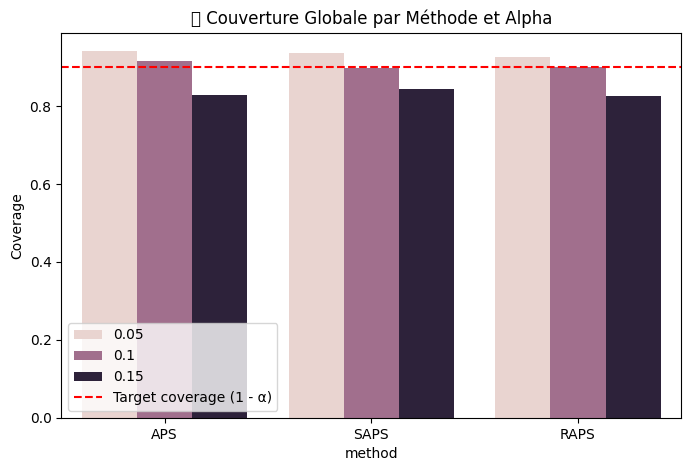

In [23]:
def clean_tensor_columns(df):
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, torch.Tensor)).any():
            df[col] = df[col].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)
    return df

results_df = clean_tensor_columns(results_df)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x="method", y="coverage", hue="alpha")
plt.axhline(0.9, color='red', linestyle='--', label="Target coverage (1 - α)")
plt.title("📏 Couverture Globale par Méthode et Alpha")
plt.ylabel("Coverage")
plt.legend()
plt.show()


**DIstribution of set size**

/home/conite/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


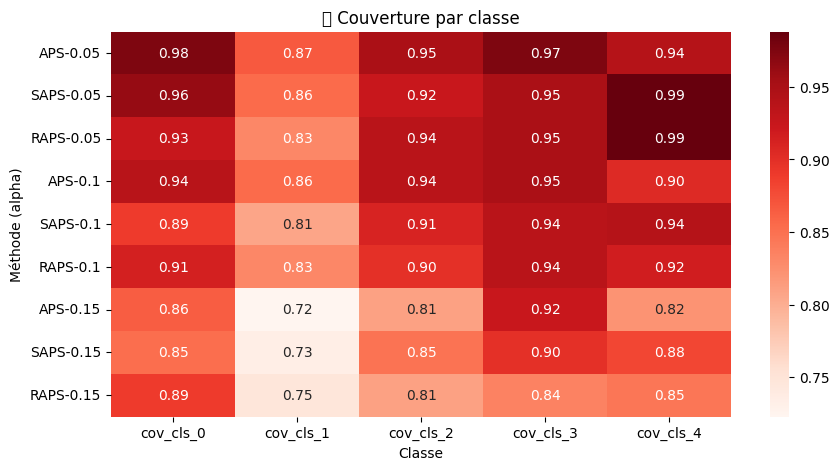

In [26]:
cov_class_cols = [col for col in results_df.columns if col.startswith("cov_cls_")]
heatmap_data = results_df.set_index(["method", "alpha"])[cov_class_cols]

plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data, annot=True, cmap="Reds", fmt=".2f")
plt.title("📉 Couverture par classe")
plt.xlabel("Classe")
plt.ylabel("Méthode (alpha)")
plt.show()


/home/conite/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


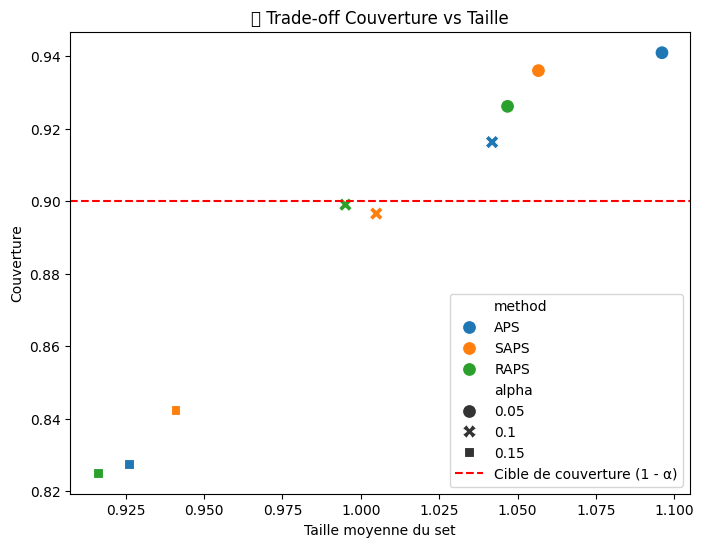

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="avg_size", y="coverage", hue="method", style="alpha", s=100)
plt.axhline(0.9, linestyle="--", color="red", label="Cible de couverture (1 - α)")
plt.title("🎯 Trade-off Couverture vs Taille")
plt.xlabel("Taille moyenne du set")
plt.ylabel("Couverture")
plt.legend()
plt.show()


In [32]:
def display_prediction_sets(model, loader, predictor, device, num_samples=5):
    model.eval()
    for i, (X_batch, y_batch) in enumerate(loader):
        X_batch = X_batch.to(device)
        sets = predictor.predict(X_batch)
        for j in range(min(num_samples, len(y_batch))):
            print(f"\nEx {j+1}:")
            print(f"Label réel : {y_batch[j].item()}")
            print(f"Prediction set : {sets[j].nonzero().flatten().tolist()}")
        break  # une seule batch
predictor = SplitPredictor(score_function=APS(score_type="softmax"), model=model)
predictor.calibrate(cal_loader, alpha=0.1)
display_prediction_sets(model, test_loader, predictor, device, num_samples=50)



Ex 1:
Label réel : 2
Prediction set : [2]

Ex 2:
Label réel : 1
Prediction set : [1]

Ex 3:
Label réel : 0
Prediction set : []

Ex 4:
Label réel : 1
Prediction set : [1]

Ex 5:
Label réel : 1
Prediction set : []

Ex 6:
Label réel : 0
Prediction set : [0]

Ex 7:
Label réel : 1
Prediction set : [1]

Ex 8:
Label réel : 1
Prediction set : [1]

Ex 9:
Label réel : 2
Prediction set : [2, 4]

Ex 10:
Label réel : 4
Prediction set : [4]

Ex 11:
Label réel : 1
Prediction set : [1]

Ex 12:
Label réel : 4
Prediction set : [4]

Ex 13:
Label réel : 3
Prediction set : [3]

Ex 14:
Label réel : 4
Prediction set : [4]

Ex 15:
Label réel : 4
Prediction set : [4]

Ex 16:
Label réel : 3
Prediction set : [3]

Ex 17:
Label réel : 2
Prediction set : [2]

Ex 18:
Label réel : 2
Prediction set : [2]

Ex 19:
Label réel : 2
Prediction set : [2]

Ex 20:
Label réel : 2
Prediction set : [2]

Ex 21:
Label réel : 1
Prediction set : [1]

Ex 22:
Label réel : 4
Prediction set : [4]

Ex 23:
Label réel : 1
Prediction set : 

/home/conite/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


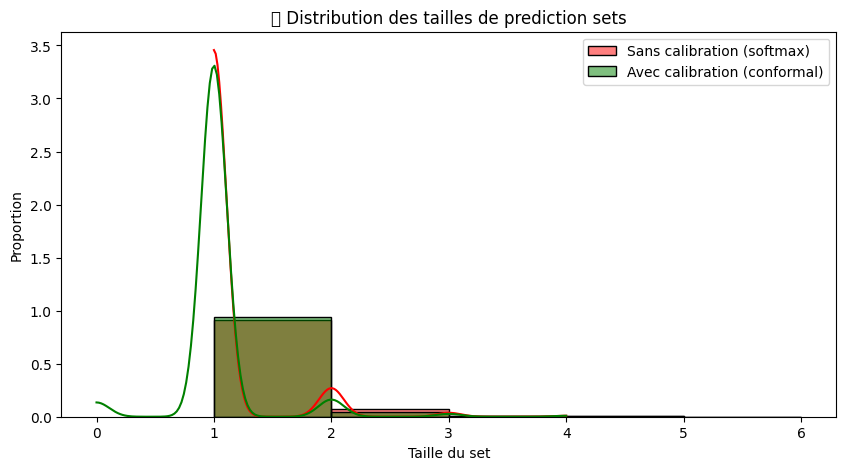

In [39]:
def get_set_size_distribution(predictor, loader, device, max_samples=1000):
    sizes = []
    count = 0
    for X_batch, _ in loader:
        X_batch = X_batch.to(device)
        sets = predictor.predict(X_batch)
        sizes += sets.sum(dim=1).tolist()
        count += len(X_batch)
        if count >= max_samples:
            break
    return sizes[:max_samples]

def get_softmax_topk_distribution(model, loader, device, threshold=0.9, max_samples=1000):
    model.eval()
    sizes = []
    count = 0
    with torch.no_grad():
        for X_batch, _ in loader:
            X_batch = X_batch.to(device)
            probs = torch.softmax(model(X_batch), dim=1)
            cum_probs, _ = torch.sort(probs, dim=1, descending=True)
            cum_sums = torch.cumsum(cum_probs, dim=1)
            k = (cum_sums < threshold).sum(dim=1) + 1
            sizes += k.tolist()
            count += len(X_batch)
            if count >= max_samples:
                break
    return sizes[:max_samples]


predictor = SplitPredictor(score_function=APS(score_type="softmax"), model=model)
predictor.calibrate(cal_loader, alpha=0.1)

sizes_conformal = get_set_size_distribution(predictor, test_loader, device)
sizes_softmax = get_softmax_topk_distribution(model, test_loader, device, threshold=0.9)

plt.figure(figsize=(10, 5))
sns.histplot(sizes_softmax, bins=range(1, 7), color="red", label="Sans calibration (softmax)", stat="probability", kde=True)
sns.histplot(sizes_conformal, bins=range(1, 7), color="green", label="Avec calibration (conformal)", stat="probability", kde=True)
plt.title("🎲 Distribution des tailles de prediction sets")
plt.xlabel("Taille du set")
plt.ylabel("Proportion")
plt.legend()
plt.show()


In [42]:
def display_failed_prediction_sets(model, test_loader, predictors, device, num_samples=5):
    """
    Affiche les prediction sets (RAPS, SAPS, ...) quand le modèle se trompe en top-1.
    """
    model.eval()
    shown = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            top1_preds = torch.argmax(logits, dim=1)

            for i in range(len(X_batch)):
                true_label = y_batch[i].item()
                top1 = top1_preds[i].item()

                if top1 != true_label: 
                    print(f"\n🔎 Exemple {shown+1}")
                    print(f"❌ Top-1 incorrect: Prédit {top1}, Réel {true_label}")

                    for name, predictor in predictors.items():
                        pred_set = predictor.predict(X_batch[i:i+1].to(device)).squeeze().nonzero(as_tuple=True)[0].tolist()
                        contains = true_label in pred_set
                        color = "✅" if contains else "❌"
                        print(f"  🔹 {name} → set = {pred_set} → {color} contient vraie classe ?")

                    shown += 1
                    if shown >= num_samples:
                        return

predictors = {
    "RAPS": SplitPredictor(score_function=RAPS(score_type="softmax"), model=model),
    "SAPS": SplitPredictor(score_function=SAPS(score_type="softmax"), model=model)
}

for p in predictors.values():
    p.calibrate(cal_loader, alpha=0.1)

display_failed_prediction_sets(model, test_loader, predictors, device, num_samples=50)



🔎 Exemple 1
❌ Top-1 incorrect: Prédit 0, Réel 1
  🔹 RAPS → set = [0, 2] → ❌ contient vraie classe ?
  🔹 SAPS → set = [0] → ❌ contient vraie classe ?

🔎 Exemple 2
❌ Top-1 incorrect: Prédit 0, Réel 1
  🔹 RAPS → set = [0] → ❌ contient vraie classe ?
  🔹 SAPS → set = [0] → ❌ contient vraie classe ?

🔎 Exemple 3
❌ Top-1 incorrect: Prédit 1, Réel 3
  🔹 RAPS → set = [1, 2] → ❌ contient vraie classe ?
  🔹 SAPS → set = [1, 2, 3] → ✅ contient vraie classe ?

🔎 Exemple 4
❌ Top-1 incorrect: Prédit 2, Réel 1
  🔹 RAPS → set = [1, 2] → ✅ contient vraie classe ?
  🔹 SAPS → set = [1, 2] → ✅ contient vraie classe ?

🔎 Exemple 5
❌ Top-1 incorrect: Prédit 1, Réel 2
  🔹 RAPS → set = [1] → ❌ contient vraie classe ?
  🔹 SAPS → set = [1] → ❌ contient vraie classe ?

🔎 Exemple 6
❌ Top-1 incorrect: Prédit 4, Réel 1
  🔹 RAPS → set = [2, 4] → ❌ contient vraie classe ?
  🔹 SAPS → set = [2, 4] → ❌ contient vraie classe ?

🔎 Exemple 7
❌ Top-1 incorrect: Prédit 2, Réel 1
  🔹 RAPS → set = [2] → ❌ contient vraie class

/home/conite/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/conite/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


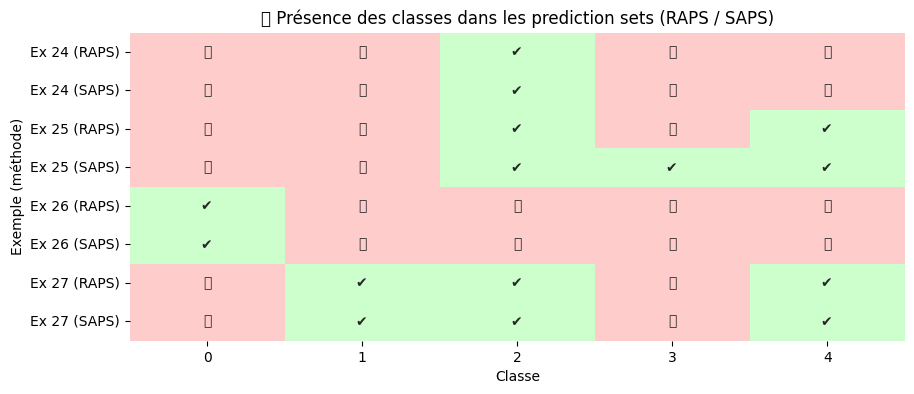

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_prediction_sets_examples(examples, class_names=None):
    """
    examples = list of dicts with keys:
        - 'index': example id
        - 'true': true label
        - 'top1': top1 prediction
        - 'RAPS': list of predicted labels
        - 'SAPS': list of predicted labels
    """
    rows = []
    for ex in examples:
        for method in ["RAPS", "SAPS"]:
            for i in range(5):  # number of classes
                rows.append({
                    "Ex": f"Ex {ex['index']} ({method})",
                    "Classe": i,
                    "Contenu": "✔️" if i in ex[method] else "❌",
                    "Vrai": i == ex['true'],
                    "Top1": i == ex['top1']
                })

    df = pd.DataFrame(rows)

    # Heatmap personnalisée avec couleurs
    pivot = df.pivot(index="Ex", columns="Classe", values="Contenu")

    plt.figure(figsize=(10, len(pivot) * 0.5))
    sns.heatmap(pivot == "✔️", annot=pivot, fmt="", cmap=["#FFCCCC", "#CCFFCC"], cbar=False)

    plt.title("🎯 Présence des classes dans les prediction sets (RAPS / SAPS)")
    plt.xlabel("Classe")
    plt.ylabel("Exemple (méthode)")
    plt.show()

examples = [
    {"index": 24, "true": 1, "top1": 2, "RAPS": [2], "SAPS": [2]},
    {"index": 25, "true": 4, "top1": 2, "RAPS": [2, 4], "SAPS": [2, 3, 4]},
    {"index": 26, "true": 1, "top1": 0, "RAPS": [0], "SAPS": [0]},
    {"index": 27, "true": 1, "top1": 2, "RAPS": [1, 2, 4], "SAPS": [1, 2, 4]},
]
plot_prediction_sets_examples(examples)
